# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [17]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200612/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2018/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/'
version = 'v1/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/'+version


os.system("mkdir -p "+ plotDir)

0

# Loading

In [3]:
data_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/'
# sig_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/'
sig_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/v1/'
SignalInput = 'CTAUSignalSummaryTableBin2Rebin.txt'
OLDSignalInput = 'SignalSummaryTableBin2Rebin.txt' 
DataInput = 'PredictionSummaryTableBin2Rebin.txt'

In [4]:

years = []
years = [
            '2016',
            '2017',
            '2018',
]

data_bin2 = {}
data_bin2err = {}

data_f=open(data_home_dir+DataInput, 'r')
for data_l in data_f:
    
    if 'Data' in data_l:
        data_ws = data_l.split('|')
        
 
        
        year = data_ws[1].split(' ')[2]
        bin2 = float(data_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(data_ws[4].lstrip(' ').rstrip(' '))
        
 
        
        data_bin2[year] = bin2
        data_bin2err[year] = bin2err
        
data_f.close()



In [5]:
data_f=open(data_home_dir+DataInput, 'r')
print(data_f.read())
data_f.close()

data_bin2_sum = 0
data_bin2_sum_err_tmp = 0
for year in years:
    print(year, data_bin2[year], data_bin2err[year])
    data_bin2_sum += data_bin2[year]
    data_bin2_sum_err_tmp += pow(data_bin2err[year],2)

data_bin2_sum_err = round(math.sqrt(data_bin2_sum_err_tmp),2)

print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.58       |          0.26          |            0.35           |            0.18            |
| Data 2017 | 1D pt  |       0.88       |          0.45          |            0.61           |            0.29            |
| Data 2016 | 1D pt  |       1.47       |          0.58          |            0.74           |            0.41            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
2016 1.47 0.58
2017 0.88 0.45
2018 0.58 0.26
Data sum 2.93
Data sum err 0.78


In [11]:
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])


In [6]:
# CTAUs = np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000]) #mm
# CTAUs=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# masses=np.array([15,40,55])
masses=np.array(['15','40','55'])
OLD_CTAU=1000 #mm
sig_bin2 = {}
sig_bin2err = {}
for mass in masses:
    sig_bin2[mass] = {}
    sig_bin2err[mass] = {}
    for year in years:
        sig_bin2[mass][year] = {}
        sig_bin2err[mass][year] = {}

sig_f=open(sig_home_dir+SignalInput, 'r')
for sig_l in sig_f:
    
    if 'ggH' in sig_l:
        sig_ws = sig_l.split('|')
        
        print('sample year',sig_ws[1].split('_')[1]) 
        print('mass',sig_ws[1].split('_')[3]) 
        print('ctau ',sig_ws[2].lstrip(' ').rstrip(' '))
        print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
        print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
        
        year_str = sig_ws[1].split('_')[1]
        if year_str=='Summer16':
            year='2016'
        elif year_str=='Fall17':
            year='2017'
        elif year_str=='Fall18':
            year='2018'
        ctau = sig_ws[2].lstrip(' ').rstrip(' ')
        mass = sig_ws[1].split('_')[3]
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
#         print(type(year))
#         print(type(bin2))
#         print(type(bin2err))
        
        sig_bin2[mass][year][ctau] = bin2
        sig_bin2err[mass][year][ctau] = bin2err
        
#         print('sample year',len(sig_ws[1].split(' ')[2].replace(',','')))
#         print('ctau ', len(sig_ws[2].lstrip(' ').rstrip(' ')))
#         print('bin 2 prediction ' , len(sig_ws[3].lstrip(' ').rstrip(' ')))
#         print('bin 2 error ', len(sig_ws[4].lstrip(' ').rstrip(' ')))
        
#         var = sig_ws[1].split(' ')[2].replace(',','')
#         var = sig_ws[3].lstrip(' ').rstrip(' ')
#         var = sig_ws[4].lstrip(' ').rstrip(' ')
#         for j in range(len(var)):
#             print(var[j])

sig_f.close()

sample year Summer16
mass 15
ctau  1
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  3
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  5
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  7
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  10
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  30
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  40
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  50
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  60
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  80
bin 2 prediction  0.0
bin 2 error  0.01
sample year Summer16
mass 15
ctau  100
bin 2 prediction  0.0
bin 2 error  0.05
sample year Summer16
mass 15
ctau  200
bin 2 prediction  0.17
bin 2 error  0.41
sample year Summer16
mass 15
ctau  300
bin 2 prediction  0.52
bin 2 error 

In [7]:
sig0_f=open(sig_home_dir+OLDSignalInput, 'r')
for sig_l in sig0_f:
    
    if 'ggH' in sig_l:
        sig_ws = sig_l.split('|')
        
#         print('sample year',sig_ws[1].split(' ')[2].replace(',',''))
#         print('ctau ', str(OLD_CTAU))
#         print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
      
        year_str = sig_ws[1].split('_')[1]
        if year_str=='Summer16':
            year='2016'
        elif year_str=='Fall17':
            year='2017'
        elif year_str=='Fall18':
            year='2018'
        ctau = str(OLD_CTAU)
        mass = sig_ws[1].split('_')[3]
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
        sig_bin2[mass][year][ctau] = bin2
        sig_bin2err[mass][year][ctau] = bin2err
        

sig0_f.close()

In [8]:
sig_f=open(sig_home_dir+SignalInput, 'r')
print(sig_f.read())
sig_f.close()

sig0_f=open(sig_home_dir+OLDSignalInput, 'r')
print(sig0_f.read())
sig0_f.close()

sig_bin2_sum = {}
sig_bin2_sum_err = {}
sig_bin2_sum_err_tmp = {}
for mass in masses:
    sig_bin2_sum[mass] ={}
    sig_bin2_sum_err[mass] ={}
    sig_bin2_sum_err_tmp[mass] ={}
    
    for ct in CTAUs:
        sig_bin2_sum[mass][str(ct)] = 0
        sig_bin2_sum_err_tmp[mass][str(ct)] = 0
        for year in years:
            print(mass, year, ct, sig_bin2[mass][year][str(ct)], sig_bin2err[mass][year][str(ct)])
            sig_bin2_sum[mass][str(ct)] += sig_bin2[mass][year][str(ct)]
            sig_bin2_sum_err_tmp[mass][str(ct)] += pow(sig_bin2err[mass][year][str(ct)], 2)


print('------------SUM----------')   
print('mass[GeV], ctau[mm], sig_sum, err')   
for mass in masses:
    for ct in CTAUs:
        sig_bin2_sum[mass][str(ct)] = round(sig_bin2_sum[mass][str(ct)],2)
        sig_bin2_sum_err[mass][str(ct)] = round(math.sqrt(sig_bin2_sum_err_tmp[mass][str(ct)]),2)
    #     print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err_tmp[str(ct)])
        print(mass, ct, sig_bin2_sum[mass][str(ct)], sig_bin2_sum_err[mass][str(ct)])


+-------------------------+-----------+-------------+-------------+
|          Sample         | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+-------------------------+-----------+-------------+-------------+
| MC_Summer16_ggH_15_1000 |     1     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     3     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     5     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     7     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     10    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     30    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     40    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     50    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     60    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     80    |     0.0     |     0.01    |
| MC_Summer16_ggH_15_1000 |    100    |     0.0     |     0.05    |
| MC_Summer16_ggH_15_1000 |    200    |     0.17

# Making Datacards

In [9]:
def make_datacard(outDataCardsDir,cardName, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred):
    text_file = open(outDataCardsDir+cardName, "w")
    text_file.write('# Simple counting experiment, with one signal and a few background processes \n')
    text_file.write('# Simplified version of the SUSY LLP analysis for mH = 200 GeV \n')

    text_file.write('imax {0} \n'.format(1))
    text_file.write('jmax {0} \n'.format(1))
    text_file.write('kmax * \n')
    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t bin1 \n')
    text_file.write('observation \t {0:6.2f} \n'.format(0))
    text_file.write('------------------------------ \n')  
    text_file.write('bin \t bin1 \t bin1 \n')
    text_file.write('process sig \t bkg \n')
    text_file.write('process 0 \t 1 \n')
    text_file.write('rate \t {0} \t {1} \n'.format(sig_yield, bkg_yield))
    text_file.write('------------------------------ \n')  
 
#     #### uncertainties ####
    text_file.write('------------------------------ \n')  
    text_file.write('lumi\t lnN \t 1.025000 \t - \n')
    text_file.write('signal_yield \t lnN  \t {0:6.6f} \t - \n'.format(1+sig_unc))    
    text_file.write('signal_stat \t lnN  \t {0} \t - \n'.format(1+sig_stat))    
    text_file.write('bkg_yield \t lnN  \t - \t {0:6.6f} \n'.format(1+bkg_unc))    
    text_file.write('bkg_pred \t lnN  \t - \t {0} \n'.format(1+bkg_pred))    

    
    text_file.close()

# Simple counting experiment, with one signal and a few background processes 
# Simplified version of the SUSY LLP analysis for mH = 200 GeV
imax 1  number of channels
jmax 1  number of backgrounds
kmax *  number of nuisance parameters (sources of systematical uncertainties)
------------
# we have just one channel, in which we observe 0 events
bin bin1
observation 0
------------
# now we list the expected events for signal and all backgrounds in that bin
# the second 'process' line must have a positive number for backgrounds, and 0 for signal
# then we list the independent sources of uncertainties, and give their effect (syst. error)
# on each process and bin
bin             bin1 bin1  
process         sig  bkg
process          0     1
rate           240  2.93
------------
lumi    lnN    1.025    -  #   lumi affects signal. lnN = lognormal
sig_yield lnN  1.2     -   #   20% uncertainty on signal yields
bkg_yield lnN  -      1.5  #   50% uncertainty on bkg yields


In [10]:
print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


Data sum 2.93
Data sum err 0.78


In [11]:
 
print('------------SUM----------')   
print('mass[GeV], ctau[mm], sig_sum, err')   
for mass in masses:
    for ct in CTAUs:
        print(mass, ct, sig_bin2_sum[mass][str(ct)], sig_bin2_sum_err[mass][str(ct)])


------------SUM----------
mass[GeV], ctau[mm], sig_sum, err
15 1 0.0 0.0
15 3 0.0 0.0
15 5 0.0 0.0
15 7 0.0 0.0
15 10 0.0 0.0
15 30 0.0 0.0
15 40 0.0 0.0
15 50 0.0 0.0
15 60 0.0 0.0
15 80 0.0 0.01
15 100 0.0 0.05
15 200 0.17 0.41
15 300 0.52 0.72
15 400 0.76 0.87
15 500 0.86 0.93
15 600 0.88 0.94
15 700 0.85 0.92
15 800 0.8 0.89
15 900 0.74 0.86
15 950 0.71 0.84
15 980 0.69 0.83
15 1000 0.68 0.82
15 1100 0.62 0.79
15 1200 0.57 0.76
15 1300 0.52 0.72
15 1400 0.48 0.69
15 1500 0.44 0.67
15 2000 0.3 0.55
15 3000 0.16 0.4
15 4000 0.1 0.32
15 5000 0.07 0.26
15 10000 0.02 0.14
40 1 0.0 0.0
40 3 0.0 0.0
40 5 0.0 0.0
40 7 0.0 0.0
40 10 0.0 0.0
40 30 0.0 0.03
40 40 0.01 0.08
40 50 0.02 0.16
40 60 0.06 0.24
40 80 0.15 0.39
40 100 0.3 0.54
40 200 1.83 1.35
40 300 3.6 1.89
40 400 4.75 2.18
40 500 5.28 2.3
40 600 5.4 2.32
40 700 5.28 2.3
40 800 5.04 2.25
40 900 4.74 2.17
40 950 4.58 2.14
40 980 4.49 2.12
40 1000 4.42 2.11
40 1100 4.11 2.02
40 1200 3.81 1.95
40 1300 3.52 1.88
40 1400 3.27 1.81
40 15

In [12]:
sig_bin2_sum_arr = {}
sig_bin2_sum_err_arr = {}
for mass in masses:
    sig_bin2_sum_arr[mass] =[]
    sig_bin2_sum_err_arr[mass] =[]
    for ct in CTAUs:
        sig_bin2_sum_arr[mass].append(sig_bin2_sum[mass][str(ct)])
        sig_bin2_sum_err_arr[mass].append(sig_bin2_sum_err[mass][str(ct)])
    
    sig_bin2_sum_arr[mass] = np.array(sig_bin2_sum_arr[mass])
    sig_bin2_sum_err_arr[mass] = np.array(sig_bin2_sum_err_arr[mass])
    
# sig_bin2_sum_arr = np.array(sig_bin2_sum_arr)
# sig_bin2_sum_err_arr = np.array(sig_bin2_sum_err_arr)

print(sig_bin2_sum_arr)
print(sig_bin2_sum_err_arr)

npts=len(CTAUs)
ctaus_err = np.zeros(npts)
print(ctaus_err)

{'15': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.17, 0.52, 0.76, 0.86, 0.88, 0.85, 0.8 , 0.74, 0.71, 0.69, 0.68,
       0.62, 0.57, 0.52, 0.48, 0.44, 0.3 , 0.16, 0.1 , 0.07, 0.02]), '40': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.06, 0.15, 0.3 ,
       1.83, 3.6 , 4.75, 5.28, 5.4 , 5.28, 5.04, 4.74, 4.58, 4.49, 4.42,
       4.11, 3.81, 3.52, 3.27, 3.04, 2.14, 1.2 , 0.76, 0.51, 0.15]), '55': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.95, 2.72, 4.23, 5.36, 6.22, 6.87, 7.33, 7.65, 7.76, 7.81, 7.84,
       7.92, 7.93, 7.87, 7.77, 7.62, 6.67, 4.8 , 3.49, 2.61, 0.9 ])}
{'15': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.05,
       0.41, 0.72, 0.87, 0.93, 0.94, 0.92, 0.89, 0.86, 0.84, 0.83, 0.82,
       0.79, 0.76, 0.72, 0.69, 0.67, 0.55, 0.4 , 0.32, 0.26, 0.14]), '40': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.08, 0.16, 0.24, 0.39, 0.54,
       1.35, 1.89, 2.18, 2.3 , 2.32

137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v1/SignalYield_m15.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v1/SignalYield_m40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v1/SignalYield_m55.png has been created


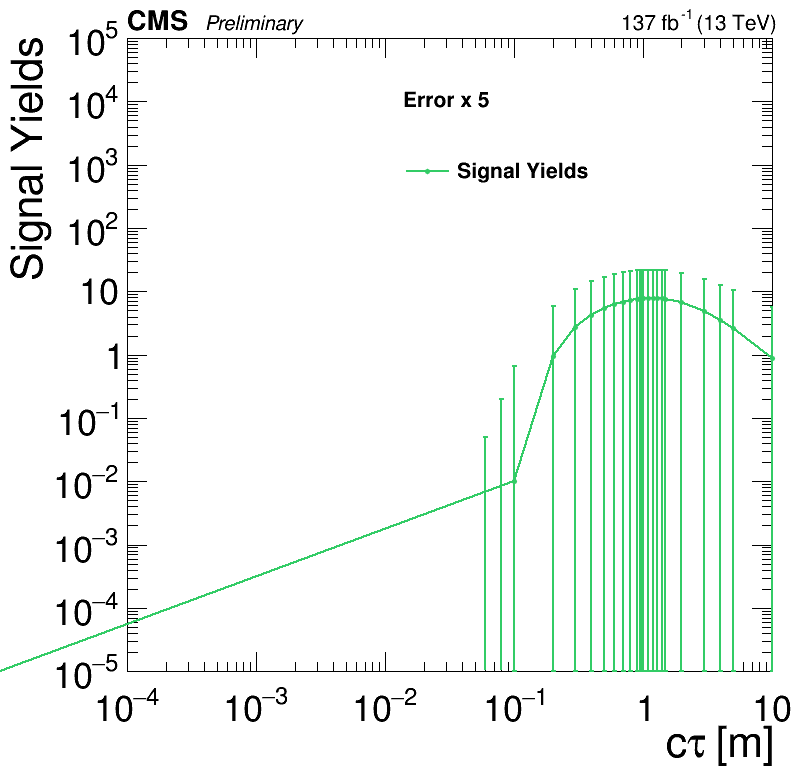

In [18]:
# plot 
ctaus_m = CTAUs/1000
for mass in masses:
    
    rt.gStyle.SetOptFit(1011)    

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    h_sig = rt.TGraphErrors(npts, ctaus_m, sig_bin2_sum_arr[mass], ctaus_err, sig_bin2_sum_err_arr[mass]*5)


    h_sig.SetTitle(" ; c#tau [m];Signal Yields");
    leg.AddEntry(h_sig, "Signal Yields", "PL")
    leg.SetHeader( "Error x 5")
    h_sig.SetLineColor(845)
    h_sig.SetLineWidth(2)
    h_sig.SetMarkerColor(845)
    h_sig.SetMarkerStyle(20)
    h_sig.SetMarkerSize(0.5)
    h_sig.GetXaxis().SetLimits(0.0001,10.0)
    h_sig.GetYaxis().SetRangeUser(1e-5,1e+5)
    h_sig.GetXaxis().SetTitleOffset(1)

    h_sig.Draw('ALPsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
#     outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v0/'
    outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/'+version

    os.system("mkdir -p "+ outDir)
    c.SaveAs(outDir+'SignalYield_m'+mass+'.png')

In [15]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v0/'

# os.system("mkdir -p "+ plotDir)
for mass in masses:
    for ct in CTAUs:
        card_name = 'ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt'
        if sig_bin2_sum[mass][str(ct)] !=0:
            sig_unc = sig_bin2_sum_err[mass][str(ct)] / sig_bin2_sum[mass][str(ct)]
#             print(sig_unc)
        else:
            sig_unc = 0.2
        sig_stat = 0.2
        bkg_unc = data_bin2_sum_err / data_bin2_sum
        bkg_pred = 0.5
        sig_yield = sig_bin2_sum[mass][str(ct)]
        bkg_yield = data_bin2_sum
        make_datacard(plotDir, card_name, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred)
        print(plotDir+card_name)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau1.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau3.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau5.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau7.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau10.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau30.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau40.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau50.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau60.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau80.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau100.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/2020

In [16]:
for mass in masses:
    for ct in CTAUs:
        if ct>10:
            card_name = 'ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt'
        #     print(plotDir+card_name)
            print('combine -M AsymptoticLimits '+plotDir+card_name+' -n _ggH_LLP_m'+mass+'_ctau'+str(ct)+'  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt' )


combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau30.txt -n _ggH_LLP_m15_ctau30  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau30.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau40.txt -n _ggH_LLP_m15_ctau40  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau40.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau50.txt -n _ggH_LLP_m15_ctau50  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau50.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau60.txt -n _ggH_LLP_m15_ctau60  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau60.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v1/ggH_LLP_m15_ctau80.t

# Limit plot

In [45]:
# rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/ggH_LLP_V1p17_v0/'
rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/ggH_LLP_V1p17_v1/'
rtFiles = {}
rtTrees = {}
Limits = {}
LimitErrs = {}
# CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# masses=np.array(['15','40','55'])

for mass in masses:
    rtFiles[mass] = {}
    rtTrees[mass] = {}
    Limits[mass] = {}
    LimitErrs[mass] = {}
    for ct in CTAUs:
        if ct>10:
            rtName = 'higgsCombine_ggH_LLP_m'+mass+'_ctau'+str(ct)+'.AsymptoticLimits.mH125.root'
            print('ctau ', ct, ' mm')
        #     print(rtName)
            rtFiles[mass][str(ct)] = rtDir+rtName

            root_dir = uproot.open(rtFiles[mass][str(ct)])
            rtTrees[mass][str(ct)] = root_dir['limit']

            print( "-2\u03C3 , -\u03C3 , exp, +\u03C3 , +2\u03C3 , obs")
            v = rtTrees[mass][str(ct)]
            limit = v['limit'].array()
            print(limit)
            limitErr = v['limitErr'].array()
            print(limitErr)

            Limits[mass][str(ct)] = limit
            LimitErrs[mass][str(ct)] = limitErr


ctau  30  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  40  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  50  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  60  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  80  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  100  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 199.21875    1073.27519922]
[0.         4.12640078]
ctau  200  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 25.86152458  48.43364334 116.15000153 233.74664307 352.26199341
 116.47381685]
[0.         0.         0.         0.         0.         0.36747275]
ctau  300  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 6.75253916 11.16744995 22.45000076 45.17961502 68.08679962 22.52198043]
[0.         0.         0.         0.         0.         0.05411183]
ctau  400  mm
-2σ , -σ , exp, 

In [43]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

start_t = time.time()
# CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([  30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000])
# CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([   200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# masses=np.array(['55' ])
# CTAUs=np.array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# masses=np.array(['40' ])
CTAUs=np.array([ 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000 ])
masses=np.array(['15' ])
# masses=np.array(['15','40','55'])
ctaus_m = CTAUs/1000
# npts = len(CTAUs)
npts = len(ctaus_m)
# print(npts)
# print(ctaus_m)
ctaus_2m = np.array(np.hstack((ctaus_m, np.flip(ctaus_m)))) 
# print(ctaus_2m)

# XSEC = 1e-03*1335.62*0.5824*0.5824 #pb
# print(XSEC)

expL = {}
exp1sigP = {}
exp1sigM = {}
exp2sigP = {}
exp2sigM = {}
exp1sig = {}
exp2sig = {}
for mass in masses:
    expL[mass] = []
    exp1sigP[mass] = []
    exp1sigM[mass] = []
    exp2sigP[mass] = []
    exp2sigM[mass] = []
    exp1sig[mass] = []
    exp2sig[mass] = []
    for ct in CTAUs:
        ctau = str(ct)
#         print(mass,ct)
#         print(Limits[mass][ctau])
#         print(Limits[mass][ctau][2])
        expL[mass].append(Limits[mass][ctau][2])
        exp1sigP[mass].append(Limits[mass][ctau][1])
        exp1sigM[mass].append(Limits[mass][ctau][3])
        exp2sigP[mass].append(Limits[mass][ctau][0])
        exp2sigM[mass].append(Limits[mass][ctau][4])
        
    expL[mass] = np.array(expL[mass])
    exp1sigP[mass]= np.array(exp1sigP[mass])
    exp1sigM[mass]= np.array(exp1sigM[mass])
    exp2sigP[mass]= np.array(exp2sigP[mass])
    exp2sigM[mass]= np.array(exp2sigM[mass])

    print(expL[mass])
    print(exp1sigP[mass])
    print(exp1sigM[mass])
    
    exp1sig[mass] = np.array(np.hstack((exp1sigP[mass], np.flip(exp1sigM[mass])))) 
    exp2sig[mass] = np.array(np.hstack((exp2sigP[mass], np.flip(exp2sigM[mass])))) 
    
# expL = np.array(expL)
# exp1sig= np.array(exp1sig)
# exp2sig= np.array(exp2sig)
# exp1sigP= np.array(exp1sigP)
# exp1sigM= np.array(exp1sigM)
# exp2sigP= np.array(exp2sigP)
# exp2sigM= np.array(exp2sigM)

print(expL)

[116.15000153  22.45000076  13.32499981  11.32499981  10.97500038
  11.44999981  12.39999962  13.85000038  14.60000038  15.19999981
  15.44999981  17.64999962  19.89999962  22.45000076  25.10000038
  28.70000076  49.79999924 128.3500061  200.        ]
[ 48.43364334  11.16744995   6.92316055   6.00603771   5.82042122
   6.07232952   6.54208946   7.15746784   7.54505634   7.81291485
   7.94141674   8.92841816   9.95485783  11.16744995  12.34471416
  13.79383278  22.79966927  52.36153793 102.58789062]
[233.74664307  45.17961502  26.81596184  22.79105186  22.08669281
  23.04260826  24.95443916  27.87250137  29.38184166  30.58931351
  31.09242821  35.5198288   40.04785156  45.17961502  50.51261902
  57.75745773 100.22025299 258.29858398 402.4909668 ]
{'15': array([116.15000153,  22.45000076,  13.32499981,  11.32499981,
        10.97500038,  11.44999981,  12.39999962,  13.85000038,
        14.60000038,  15.19999981,  15.44999981,  17.64999962,
        19.89999962,  22.45000076,  25.10000038,

[116.15000153  22.45000076  13.32499981  11.32499981  10.97500038
  11.44999981  12.39999962  13.85000038  14.60000038  15.19999981
  15.44999981  17.64999962  19.89999962  22.45000076  25.10000038
  28.70000076  49.79999924 128.3500061  200.        ]
137 fb^{-1} (13 TeV)
0.47071027755737305


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v1/Limit_m15.png has been created


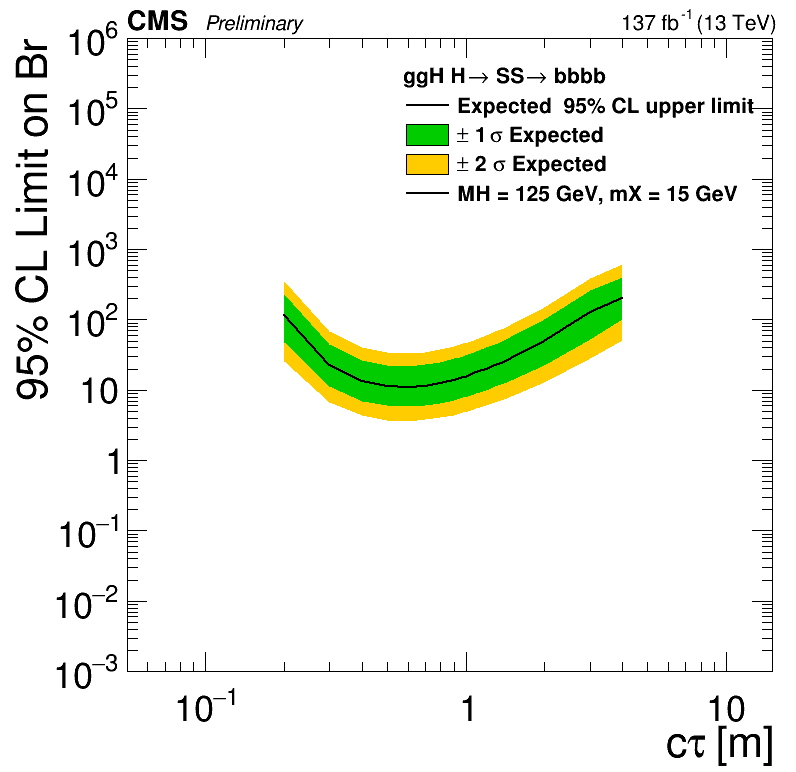

In [44]:
XSEC =  4.858E+01*0.5824*0.5824 #pb

for mass in masses:
    print(expL[mass])
    
    rt.gStyle.SetOptFit(1011)

    # h_exp = {}
    # h_exp1sig = {}
    # h_exp2sig = {}


    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

#     h_exp = create_TGraph(ctaus_m, expL[mass],  axis_title=['c#tau [m]', '95% CL Limit on xsec[pb]'])
    h_exp = create_TGraph(ctaus_m, expL[mass],  axis_title=['c#tau [m]', '95% CL Limit on Br'])

    h_exp1sig = create_TGraph(ctaus_2m,  exp1sig[mass])
#     h_exp1sig = create_TGraph(ctaus_2m,  exp1sig[mass]*XSEC)
    h_exp2sig = create_TGraph(ctaus_2m,  exp2sig[mass])
#     h_exp2sig = create_TGraph(ctaus_2m,  exp2sig[mass]*XSEC)


    leg.AddEntry(h_exp, "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')
    leg.SetHeader('ggH H#rightarrow SS#rightarrow bbbb')
    leg.AddEntry(h_exp, "MH = 125 GeV, mX = "+mass+" GeV")
    h_exp.SetLineColor(1)
    h_exp.SetLineWidth(2)
    h_exp1sig.SetFillColor(417)
    h_exp2sig.SetFillColor(800)
    h_exp.GetXaxis().SetLimits(0.05,15.0)
    h_exp.GetYaxis().SetRangeUser(1e-3,1e+6)
    h_exp.GetXaxis().SetTitleOffset(1)

    h_exp.Draw('LA')
    h_exp2sig.Draw( 'Fsame')
    h_exp1sig.Draw('Fsame')
    h_exp.Draw('Lsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
    print(time.time()-start_t) 
    LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/'+version

    os.system("mkdir -p "+ LimDir)
    c.SaveAs(LimDir+'Limit_m'+mass+'.png')